<a href="https://colab.research.google.com/github/alka62/KNN-Classification-Iris-Dataset/blob/main/KNN_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving archive (7).zip to archive (7) (3).zip
Extracted files: ['database.sqlite', 'Iris.csv']
Dataset Preview:
   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa
K=1 → Accuracy: 0.97
K=3 → Accuracy: 1.00
K=5 → Accuracy: 1.00
K=7 → Accuracy: 1.00
K=9 → Accuracy: 1.00

Best K value: 3

Confusion Matrix:


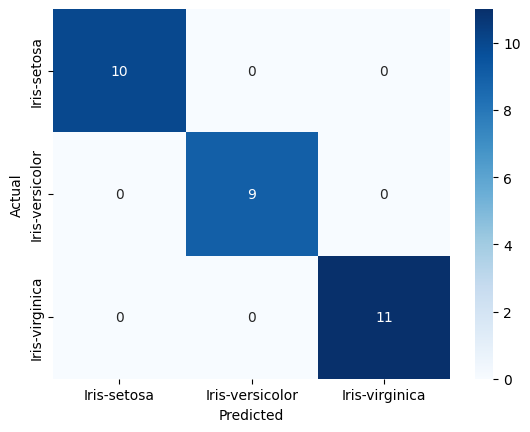


Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00         9
 Iris-virginica       1.00      1.00      1.00        11

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30



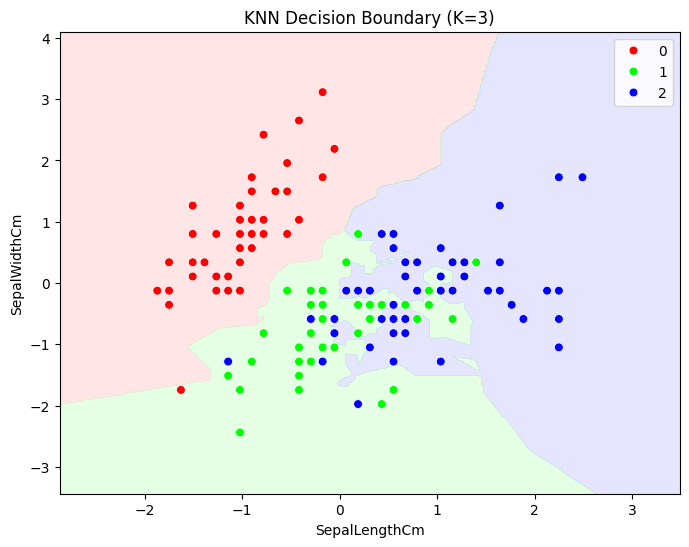

In [6]:
# ===== Task 6: KNN Classification with ZIP Extraction =====

# Step 1: Upload ZIP and Extract CSV
from google.colab import files
import zipfile
import io
import pandas as pd
import os

uploaded = files.upload()
zip_filename = list(uploaded.keys())[0]  # e.g., archive (7).zip

# Extract ZIP file
with zipfile.ZipFile(io.BytesIO(uploaded[zip_filename]), 'r') as zip_ref:
    zip_ref.extractall("dataset")

print("Extracted files:", os.listdir("dataset"))

# Read CSV (try multiple encodings to avoid UnicodeDecodeError)
csv_file = None
for file in os.listdir("dataset"):
    if file.lower().endswith(".csv"):
        csv_file = os.path.join("dataset", file)
        break

if csv_file is None:
    raise FileNotFoundError("No CSV file found inside the ZIP!")

try:
    df = pd.read_csv(csv_file, encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv(csv_file, encoding='latin1')

print("Dataset Preview:")
print(df.head())

# Remove ID column if present
if 'Id' in df.columns:
    df = df.drop('Id', axis=1)

# Step 2: Features & Target
if 'Species' not in df.columns:
    raise KeyError("'Species' column not found in dataset! Check CSV content.")

X = df.drop('Species', axis=1)
y = df['Species']

# Step 3: Normalize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 5: Try different K values
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

k_values = [1, 3, 5, 7, 9]
accuracies = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"K={k} → Accuracy: {acc:.2f}")

# Step 6: Best K
best_k = k_values[np.argmax(accuracies)]
print(f"\nBest K value: {best_k}")

# Step 7: Train final model
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Step 8: Evaluation
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=df['Species'].unique(), yticklabels=df['Species'].unique())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 9: Decision Boundary (only first 2 features for visualization)
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder

X_vis = X_scaled[:, :2]  # Only first two features for plotting
# Use the full training data for visualization to get a more representative boundary
X_train_vis = X_scaled[:, :2]
y_train_vis = y

le = LabelEncoder()
y_encoded = le.fit_transform(y) # Fit and transform the full dataset labels
y_train_vis_encoded = le.transform(y_train_vis) # Transform training labels for fitting knn_vis

knn_vis = KNeighborsClassifier(n_neighbors=best_k)
knn_vis.fit(X_train_vis, y_train_vis_encoded) # Fit with encoded training labels

x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z_encoded = knn_vis.predict(np.c_[xx.ravel(), yy.ravel()]) # Get encoded predictions
Z_encoded = Z_encoded.reshape(xx.shape)

plt.figure(figsize=(8, 6))
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ['#FF0000', '#00FF00', '#0000FF']

# Use numerical levels for contourf
plt.contourf(xx, yy, Z_encoded, alpha=0.3, cmap=cmap_light, levels=np.arange(len(le.classes_) + 1) - 0.5)
sns.scatterplot(x=X_vis[:, 0], y=X_vis[:, 1], hue=y_encoded, palette=cmap_bold, s=40, legend='full') # Use encoded y for hue
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[1])
plt.title(f"KNN Decision Boundary (K={best_k})")
plt.show()